In [1]:
!pip install pandas


[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python3 -m pip install --upgrade pip


In [2]:
import sys
sys.path.append('../../CppToPython')

import numpy as np
import GeDiM4Py as gedim
from scipy.sparse.linalg import splu
import time
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import torch
import torch.nn as nn
from torch.autograd import Variable

# Run to avoid to many warnings
import warnings
warnings.filterwarnings('ignore')

import torch.nn.functional as F
from torch.optim.lr_scheduler import CosineAnnealingLR
import os
import pandas as pd

In [3]:
lib = gedim.ImportLibrary("../../CppToPython/release/GeDiM4Py.so")

config = { 'GeometricTolerance': 1.0e-8 }
gedim.Initialize(config, lib)

np.random.seed(23)

In [4]:
# Just for the first epoch
def generate_data(N_domain=1750, N_boundary=150):
    # Points in the domain
    x_in = torch.rand((N_domain, 2))  # [x0, x1] ∈ Ω
    mu_in = (torch.rand((1, 2)) * 0.9 + 0.1).expand(N_domain, -1) # [mu0, mu1] ∈ [0.1, 1]^2

    # Points on the border of the domain (edge of the square)
    x0 = torch.rand(N_boundary, 1)
    zeros = torch.zeros_like(x0)
    ones = torch.ones_like(x0)

    xb = torch.cat([
        torch.cat([x0, zeros], dim=1),
        torch.cat([x0, ones], dim=1),
        torch.cat([zeros, x0], dim=1),
        torch.cat([ones, x0], dim=1)
    ], dim=0)

    mu_b = mu_in[:N_boundary*4, :]
    return x_in, mu_in, xb, mu_b

In [5]:
# For all the other epochs, it samples on the point on the domain in which the loss is higher so that he can learn better
def adaptive_sample(model, N_tot=5000, N_sel=1750, N_boundary=150):
    X = torch.rand(N_tot, 2)
    M = (torch.rand(N_tot, 2) * 0.9 + 0.1)

    # Compute the residual
    X.requires_grad_(True)
    R_vals = R(X, M, model).detach().abs().cpu().numpy().flatten()  # .detach() spezza il grafo

    idx = np.argsort(R_vals)[-N_sel:]
    x_int = X.detach()[idx]  
    mu_int = M.detach()[idx]

    # Point on the border
    x0 = torch.rand(N_boundary, 1)
    zeros = torch.zeros_like(x0)
    ones = torch.ones_like(x0)
    xb = torch.cat([
        torch.cat([x0, zeros], 1),
        torch.cat([x0, ones], 1),
        torch.cat([zeros, x0], 1),
        torch.cat([ones, x0], 1)
    ], 0)
    mu_b = (torch.rand(1, 2) * 0.9 + 0.1).expand(xb.shape[0], -1)

    return x_int, mu_int, xb, mu_b

In [6]:
# x: [N, 2], mu: [N, 2]
def R(x, mu, net):
    x.requires_grad_(True)
    mu.requires_grad_(False)

    u = net(x, mu)  # output shape: [N, 1]

    # Compute the gradient ∇u (i.e. du/dx e du/dy)
    grads = torch.autograd.grad(u.sum(), x, create_graph=True)[0]  # shape [N, 2]
    u_x = grads[:, 0].unsqueeze(1)  # du/dx
    u_y = grads[:, 1].unsqueeze(1)  # du/dy

    # Laplacian = d²u/dx² + d²u/dy²
    u_xx = torch.autograd.grad(u_x.sum(), x, create_graph=True)[0][:, 0].unsqueeze(1)
    u_yy = torch.autograd.grad(u_y.sum(), x, create_graph=True)[0][:, 1].unsqueeze(1)
    laplacian_u = u_xx + u_yy

    # Nonlinear term
    mu0 = mu[:, 0].unsqueeze(1)
    mu1 = mu[:, 1].unsqueeze(1)
    nonlinear = (mu0 / mu1) * (torch.exp(mu1 * u) - 1)

    # Forcing term g(x)
    x0 = x[:, 0].unsqueeze(1)
    x1 = x[:, 1].unsqueeze(1)
    g = 100 * torch.sin(2 * torch.pi * x0 * mu0) * torch.cos(2 * torch.pi * x1 * mu0)

    # Residuo della PDE
    residual = -laplacian_u + nonlinear - g

    return residual

In [10]:
def train(model, epochs=50000, lr=1e-3, lambda_bc=1.0, patience=7500, delta=1e-4, batch_size=None, save_path="./models"):
    os.makedirs(save_path, exist_ok=True)
    start_time_total = time.time()  # ⏱ Inizio del timer totale

    mse_loss = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    current_optimizer_name = "Adam" # Inizializza il nome dell'ottimizzatore

    best_phys_loss = float('inf')
    best_model_state = None
    best_model_path = None
    epochs_no_improve = 0
    using_lbfgs = False

    loss_history_total = []
    loss_history_phys = []
    loss_history_bc = []
    times_per_epoch = []

    for epoch in range(epochs):
        start_time = time.time()
        model.train()
        x_in, mu_in, xb, mu_b = generate_data()

        if epoch != 0:
            x_in, mu_in, xb, mu_b = adaptive_sample(model)

        try:
            if not using_lbfgs:
                optimizer.zero_grad()
                loss_phys = mse_loss(R(x_in, mu_in, model), torch.zeros_like(x_in[:, :1]))
                u_b = model(xb, mu_b)
                loss_bc = mse_loss(u_b, torch.zeros_like(u_b))

                loss_total = loss_phys + lambda_bc * loss_bc

                if torch.isnan(loss_total):
                    raise ValueError("NaN detected in Adam loss computation")

                loss_total.backward()
                optimizer.step()

                if loss_phys.item() + delta < best_phys_loss:
                    best_phys_loss = loss_phys.item()
                    best_model_state = model.state_dict()
                    best_model_path = os.path.join(save_path, f"model_best.pth")
                    torch.save(best_model_state, best_model_path)
                    torch.save(best_model_state, "PINNResNet.pth")
                    epochs_no_improve = 0
                else:
                    epochs_no_improve += 1

                if loss_total.item() < 1e-4:
                    final_model_path = os.path.join(save_path, "model_total_loss_e-4_PINNResNet.pth")
                    torch.save(model.state_dict(), final_model_path)
                    print(f"\n💾 Total loss reached e-4 at epoch {epoch}. Model saved at {final_model_path}")
                    break

                if loss_phys.item() < 5e-1:
                    print(f"\n🔁 Switching to LBFGS at epoch {epoch}")
                    using_lbfgs = True
                    optimizer = torch.optim.LBFGS(model.parameters(), lr=1.0, max_iter=500)
                    current_optimizer_name = "LBFGS" # Aggiorna il nome dell'ottimizzatore
                    if best_model_state:
                        model.load_state_dict(best_model_state)

            else: # LBFGS optimizer
                def closure():
                    optimizer.zero_grad()
                    loss_phys_cl = mse_loss(R(x_in, mu_in, model), torch.zeros_like(x_in[:, :1]))
                    u_b_cl = model(xb, mu_b)
                    loss_bc_cl = mse_loss(u_b_cl, torch.zeros_like(u_b_cl))
                    loss_total_cl = loss_phys_cl + lambda_bc * loss_bc_cl

                    if torch.isnan(loss_total_cl):
                        raise ValueError("NaN detected in LBFGS loss computation")

                    loss_total_cl.backward()
                    return loss_total_cl

                optimizer.step(closure)

                # Dopo l'ottimizzazione LBFGS, ricalcola le perdite per la stampa
                loss_phys = mse_loss(R(x_in, mu_in, model), torch.zeros_like(x_in[:, :1]))
                u_b = model(xb, mu_b)
                loss_bc = mse_loss(u_b, torch.zeros_like(u_b))
                loss_total = loss_phys + lambda_bc * loss_bc

                if loss_total.item() < 1e-3: # Condizione per terminare anche con LBFGS
                    final_model_path = os.path.join(save_path, "model_total_loss_e-4_PINNResNet.pth")
                    torch.save(model.state_dict(), final_model_path)
                    print(f"\n💾 Total loss reached e-4 at epoch {epoch}. Model saved at {final_model_path}")
                    break

        except ValueError as e:
            print(f"\n❌ Training stopped due to error at epoch {epoch}: {str(e)}")
            if best_model_state:
                print("🔄 Reverting to best model state before NaN.")
                model.load_state_dict(best_model_state)
                torch.save(best_model_state, "PINNResNet.pth")
                nan_model_path = os.path.join(save_path, f"model_nan_epoch{epoch}.pth")
                torch.save(model.state_dict(), nan_model_path)
            break

        loss_history_total.append(loss_total.item())
        loss_history_phys.append(loss_phys.item())
        loss_history_bc.append(loss_bc.item())
        times_per_epoch.append(time.time() - start_time)

        # Logica di stampa condizionale
        if using_lbfgs:
            # Stampa a ogni epoca quando si usa LBFGS
            print(f"[{current_optimizer_name}] Epoch {epoch} - Total: {loss_total.item():.2e} | PDE: {loss_phys.item():.2e} | BC: {loss_bc.item():.2e}")
        elif epoch % 500 == 0 or epoch == epochs - 1:
            # Stampa ogni 500 epoche o all'ultima epoca per Adam
            print(f"[{current_optimizer_name}] Epoch {epoch} - Total: {loss_total.item():.2e} | PDE: {loss_phys.item():.2e} | BC: {loss_bc.item():.2e}")

        if not using_lbfgs and epochs_no_improve >= patience:
            print(f"\n🛑 Early stopping at epoch {epoch} | Best PDE loss: {best_phys_loss:.2e}")
            model.load_state_dict(best_model_state)
            break

    # Salva comunque il modello finale
    final_model_path = os.path.join(save_path, "model_final.pth")
    torch.save(model.state_dict(), final_model_path)

    # Plotta le perdite
    plt.figure(figsize=(10, 5))
    plt.plot(loss_history_total, label='Total Loss')
    plt.plot(loss_history_phys, label='PDE Loss')
    plt.plot(loss_history_bc, label='BC Loss')
    plt.yscale('log')
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Loss trends over training")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Statistiche finali sul tempo
    total_epochs = len(loss_history_total)
    avg_time = sum(times_per_epoch) / total_epochs
    total_time = time.time() - start_time_total
    print(f"\n✅ Training complete: {total_epochs} epochs")
    print(f"⏱ Average time per epoch: {avg_time:.4f} seconds")
    print(f"⏱ Total training time: {total_time:.2f} seconds")

    return None


In [8]:
def validation(model, epochs=10, lambda_bc=1.0):
   
    mse_loss = nn.MSELoss()
    loss_bc = 1
    loss_phys = 1 

    for epoch in range(epochs):   
             
        x_in, mu_in, xb, mu_b = generate_data()
        
        model.eval()

        # Phiycial Loss (residual PDE)
        loss_phys = mse_loss(R(x_in, mu_in, model), torch.zeros_like(x_in[:, :1]))

        # Boundary Loss (Dirichlet)
        u_b = model(xb, mu_b)
        loss_bc = mse_loss(u_b, torch.zeros_like(u_b))

        # Total Loss 
        loss_total = loss_phys + lambda_bc * loss_bc

        print(f"Epoch {epoch} - Loss: {loss_total.item():.6e}  [PDE: {loss_phys.item():.2e}, BC: {loss_bc.item():.2e}]")

[Adam] Epoch 0 - Total: 2.53e+03 | PDE: 2.53e+03 | BC: 0.00e+00
[Adam] Epoch 500 - Total: 2.86e+03 | PDE: 2.86e+03 | BC: 0.00e+00
[Adam] Epoch 1000 - Total: 1.21e+03 | PDE: 1.21e+03 | BC: 0.00e+00
[Adam] Epoch 1500 - Total: 5.19e+02 | PDE: 5.19e+02 | BC: 0.00e+00
[Adam] Epoch 2000 - Total: 2.53e+02 | PDE: 2.53e+02 | BC: 0.00e+00
[Adam] Epoch 2500 - Total: 1.76e+02 | PDE: 1.76e+02 | BC: 0.00e+00
[Adam] Epoch 3000 - Total: 9.08e+01 | PDE: 9.08e+01 | BC: 0.00e+00
[Adam] Epoch 3500 - Total: 7.84e+01 | PDE: 7.84e+01 | BC: 0.00e+00
[Adam] Epoch 4000 - Total: 7.24e+01 | PDE: 7.24e+01 | BC: 0.00e+00
[Adam] Epoch 4500 - Total: 7.00e+01 | PDE: 7.00e+01 | BC: 0.00e+00
[Adam] Epoch 5000 - Total: 4.45e+01 | PDE: 4.45e+01 | BC: 0.00e+00
[Adam] Epoch 5500 - Total: 3.64e+01 | PDE: 3.64e+01 | BC: 0.00e+00
[Adam] Epoch 6000 - Total: 1.99e+01 | PDE: 1.99e+01 | BC: 0.00e+00
[Adam] Epoch 6500 - Total: 2.29e+01 | PDE: 2.29e+01 | BC: 0.00e+00
[Adam] Epoch 7000 - Total: 1.53e+01 | PDE: 1.53e+01 | BC: 0.00e+00

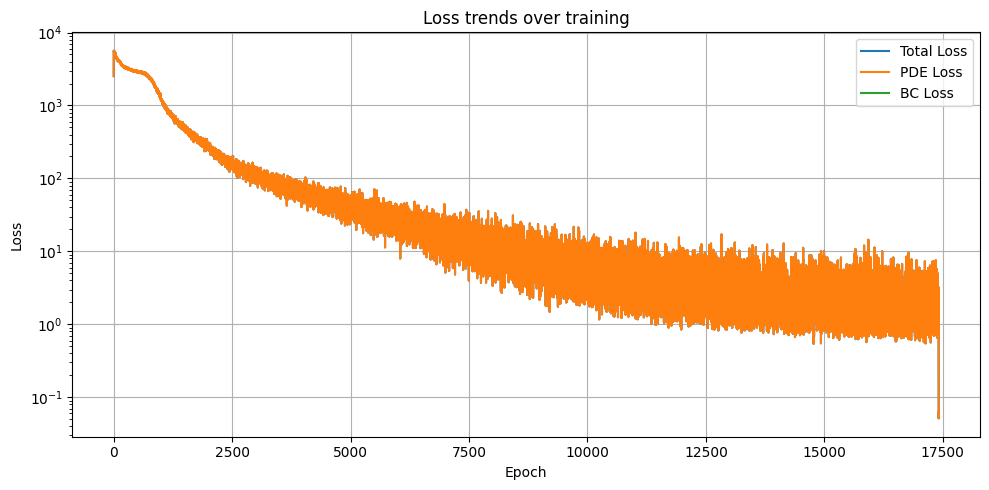


✅ Training complete: 17415 epochs
⏱ Average time per epoch: 0.0613 seconds
⏱ Total training time: 1068.91 seconds


In [11]:
# 15- PINNHardBC
def boundary_factor(x):
    return x[:,0]*(1 - x[:,0])*x[:,1]*(1 - x[:,1])  # vanish on boundary

class PINNHardBC(nn.Module):
    def __init__(self, width=60):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(4, width), nn.Tanh(),
            nn.Linear(width, width), nn.Tanh(),
            nn.Linear(width, width), nn.Tanh(),
            nn.Linear(width, 1)
        )
    def forward(self, x, mu):
        xmu = torch.cat((x, mu), dim=1)
        return boundary_factor(x).unsqueeze(1) * self.net(xmu)



PINNHardBC = PINNHardBC()
train(PINNHardBC)

#### Results
[Adam] Epoch 0 - Total: 2.53e+03 | PDE: 2.53e+03 | BC: 0.00e+00

[Adam] Epoch 500 - Total: 2.86e+03 | PDE: 2.86e+03 | BC: 0.00e+00

[Adam] Epoch 1000 - Total: 1.21e+03 | PDE: 1.21e+03 | BC: 0.00e+00

[Adam] Epoch 1500 - Total: 5.19e+02 | PDE: 5.19e+02 | BC: 0.00e+00

[Adam] Epoch 2000 - Total: 2.53e+02 | PDE: 2.53e+02 | BC: 0.00e+00

[Adam] Epoch 2500 - Total: 1.76e+02 | PDE: 1.76e+02 | BC: 0.00e+00

[Adam] Epoch 3000 - Total: 9.08e+01 | PDE: 9.08e+01 | BC: 0.00e+00

[Adam] Epoch 3500 - Total: 7.84e+01 | PDE: 7.84e+01 | BC: 0.00e+00

[Adam] Epoch 4000 - Total: 7.24e+01 | PDE: 7.24e+01 | BC: 0.00e+00

[Adam] Epoch 4500 - Total: 7.00e+01 | PDE: 7.00e+01 | BC: 0.00e+00

[Adam] Epoch 5000 - Total: 4.45e+01 | PDE: 4.45e+01 | BC: 0.00e+00

[Adam] Epoch 5500 - Total: 3.64e+01 | PDE: 3.64e+01 | BC: 0.00e+00

[Adam] Epoch 6000 - Total: 1.99e+01 | PDE: 1.99e+01 | BC: 0.00e+00

[Adam] Epoch 6500 - Total: 2.29e+01 | PDE: 2.29e+01 | BC: 0.00e+00

[Adam] Epoch 7000 - Total: 1.53e+01 | PDE: 1.53e+01 | BC: 0.00e+00

[Adam] Epoch 7500 - Total: 1.80e+01 | PDE: 1.80e+01 | BC: 0.00e+00

[Adam] Epoch 8000 - Total: 4.44e+00 | PDE: 4.44e+00 | BC: 0.00e+00

[Adam] Epoch 8500 - Total: 3.76e+00 | PDE: 3.76e+00 | BC: 0.00e+00

[Adam] Epoch 9000 - Total: 1.03e+01 | PDE: 1.03e+01 | BC: 0.00e+00

[Adam] Epoch 9500 - Total: 2.94e+00 | PDE: 2.94e+00 | BC: 0.00e+00

[Adam] Epoch 10000 - Total: 5.58e+00 | PDE: 5.58e+00 | BC: 0.00e+00

[Adam] Epoch 10500 - Total: 7.92e+00 | PDE: 7.92e+00 | BC: 0.00e+00

[Adam] Epoch 11000 - Total: 3.20e+00 | PDE: 3.20e+00 | BC: 0.00e+00

[Adam] Epoch 11500 - Total: 9.21e+00 | PDE: 9.21e+00 | BC: 0.00e+00

[Adam] Epoch 12000 - Total: 7.98e+00 | PDE: 7.98e+00 | BC: 0.00e+00

[Adam] Epoch 12500 - Total: 1.60e+00 | PDE: 1.60e+00 | BC: 0.00e+00

[Adam] Epoch 13000 - Total: 4.59e+00 | PDE: 4.59e+00 | BC: 0.00e+00

[Adam] Epoch 13500 - Total: 1.24e+00 | PDE: 1.24e+00 | BC: 0.00e+00

[Adam] Epoch 14000 - Total: 1.04e+00 | PDE: 1.04e+00 | BC: 0.00e+00

[Adam] Epoch 14500 - Total: 3.43e+00 | PDE: 3.43e+00 | BC: 0.00e+00

[Adam] Epoch 15000 - Total: 1.66e+00 | PDE: 1.66e+00 | BC: 0.00e+00

[Adam] Epoch 15500 - Total: 1.05e+00 | PDE: 1.05e+00 | BC: 0.00e+00

[Adam] Epoch 16000 - Total: 7.33e-01 | PDE: 7.33e-01 | BC: 0.00e+00

[Adam] Epoch 16500 - Total: 1.26e+00 | PDE: 1.26e+00 | BC: 0.00e+00

[Adam] Epoch 17000 - Total: 9.83e-01 | PDE: 9.83e-01 | BC: 0.00e+00

🔁 Switching to LBFGS at epoch 17412

[LBFGS] Epoch 17412 - Total: 4.97e-01 | PDE: 4.97e-01 | BC: 0.00e+00

[LBFGS] Epoch 17413 - Total: 5.14e-02 | PDE: 5.14e-02 | BC: 0.00e+00

[LBFGS] Epoch 17414 - Total: 6.24e-02 | PDE: 6.24e-02 | BC: 0.00e+00

❌ Training stopped due to error at epoch 17415: NaN detected in LBFGS loss computation

🔄 Reverting to best model state before NaN.

✅ Training complete: 17415 epochs

⏱ Average time per epoch: 0.0613 seconds

⏱ Total training time: 1068.91 seconds

In [ ]:
validation(net)  

### Results validation
For val we use the best_model and not the final one. These are the results
Epoch 0 - Loss: 2.683552e+00  [PDE: 2.68e+00, BC: 0.00e+00]

Epoch 1 - Loss: 7.320699e+02  [PDE: 7.32e+02, BC: 0.00e+00]

Epoch 2 - Loss: 1.435704e+00  [PDE: 1.44e+00, BC: 0.00e+00]

Epoch 3 - Loss: 2.375168e+03  [PDE: 2.38e+03, BC: 0.00e+00]

Epoch 4 - Loss: 1.372038e+03  [PDE: 1.37e+03, BC: 0.00e+00]

Epoch 5 - Loss: 2.126113e+03  [PDE: 2.13e+03, BC: 0.00e+00]

Epoch 6 - Loss: 2.430348e+03  [PDE: 2.43e+03, BC: 0.00e+00]

Epoch 7 - Loss: 5.606619e+02  [PDE: 5.61e+02, BC: 0.00e+00]

Epoch 8 - Loss: 2.514177e+03  [PDE: 2.51e+03, BC: 0.00e+00]

Epoch 9 - Loss: 1.590049e+03  [PDE: 1.59e+03, BC: 0.00e+00]

In [ ]:
# 15- PINNHardBC
def boundary_factor(x):
    return x[:,0]*(1 - x[:,0])*x[:,1]*(1 - x[:,1])  # vanish on boundary

class PINNHardBC(nn.Module):
    def __init__(self, width=60):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(4, width), nn.Tanh(),
            nn.Linear(width, width), nn.Tanh(),
            nn.Linear(width, width), nn.Tanh(),
            nn.Linear(width, 1)
        )
    def forward(self, x, mu):
        xmu = torch.cat((x, mu), dim=1)
        return boundary_factor(x).unsqueeze(1) * self.net(xmu)


net = PINNHardBC()
net.load_state_dict(torch.load("model_best.pth", map_location="cpu")) # CHANGE HERE THE NAME

net.eval() # Put the net in eval mode

model_name = "PINNHardBC"
save_csv_file(model_name)

sol_quad_pinn, der_x_quad_pinn, der_y_quad_pinn = csv(model_name)

errors_u_set = compute_L2_H1_errors_separated(sol_quad_hf,der_x_quad_hf,der_y_quad_hf, sol_quad_pinn,der_x_quad_pinn,der_y_quad_pinn, weights=quadratureWeights)

### Results on quadrature points
L2 absolute error (mean): 2.3796e-02

L2 relative error (mean): 2.4579e-02

H1 absolute error (mean): 9.7629e-01

H1 relative error (mean): 1.5484e-01

In [ ]:
# Finished